# Human Action Recognition in Videos using Keras

In [ ]:
# Step 1: Download and Visualize Data with its Labels

In [8]:
# type: ignore
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from pytube import YouTube

from moviepy.editor import *

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical


In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## About the Dataset

 50 Action Categories <br> 25 Groups of Videos per Action Category <br> 133 Average Videos per Action Category <br> 199 Average Number of Frames per Video <br> 320 Average Frame Width per Video <br> 240 Average Frame Height per Video <br> 26 Average Frames per second per video

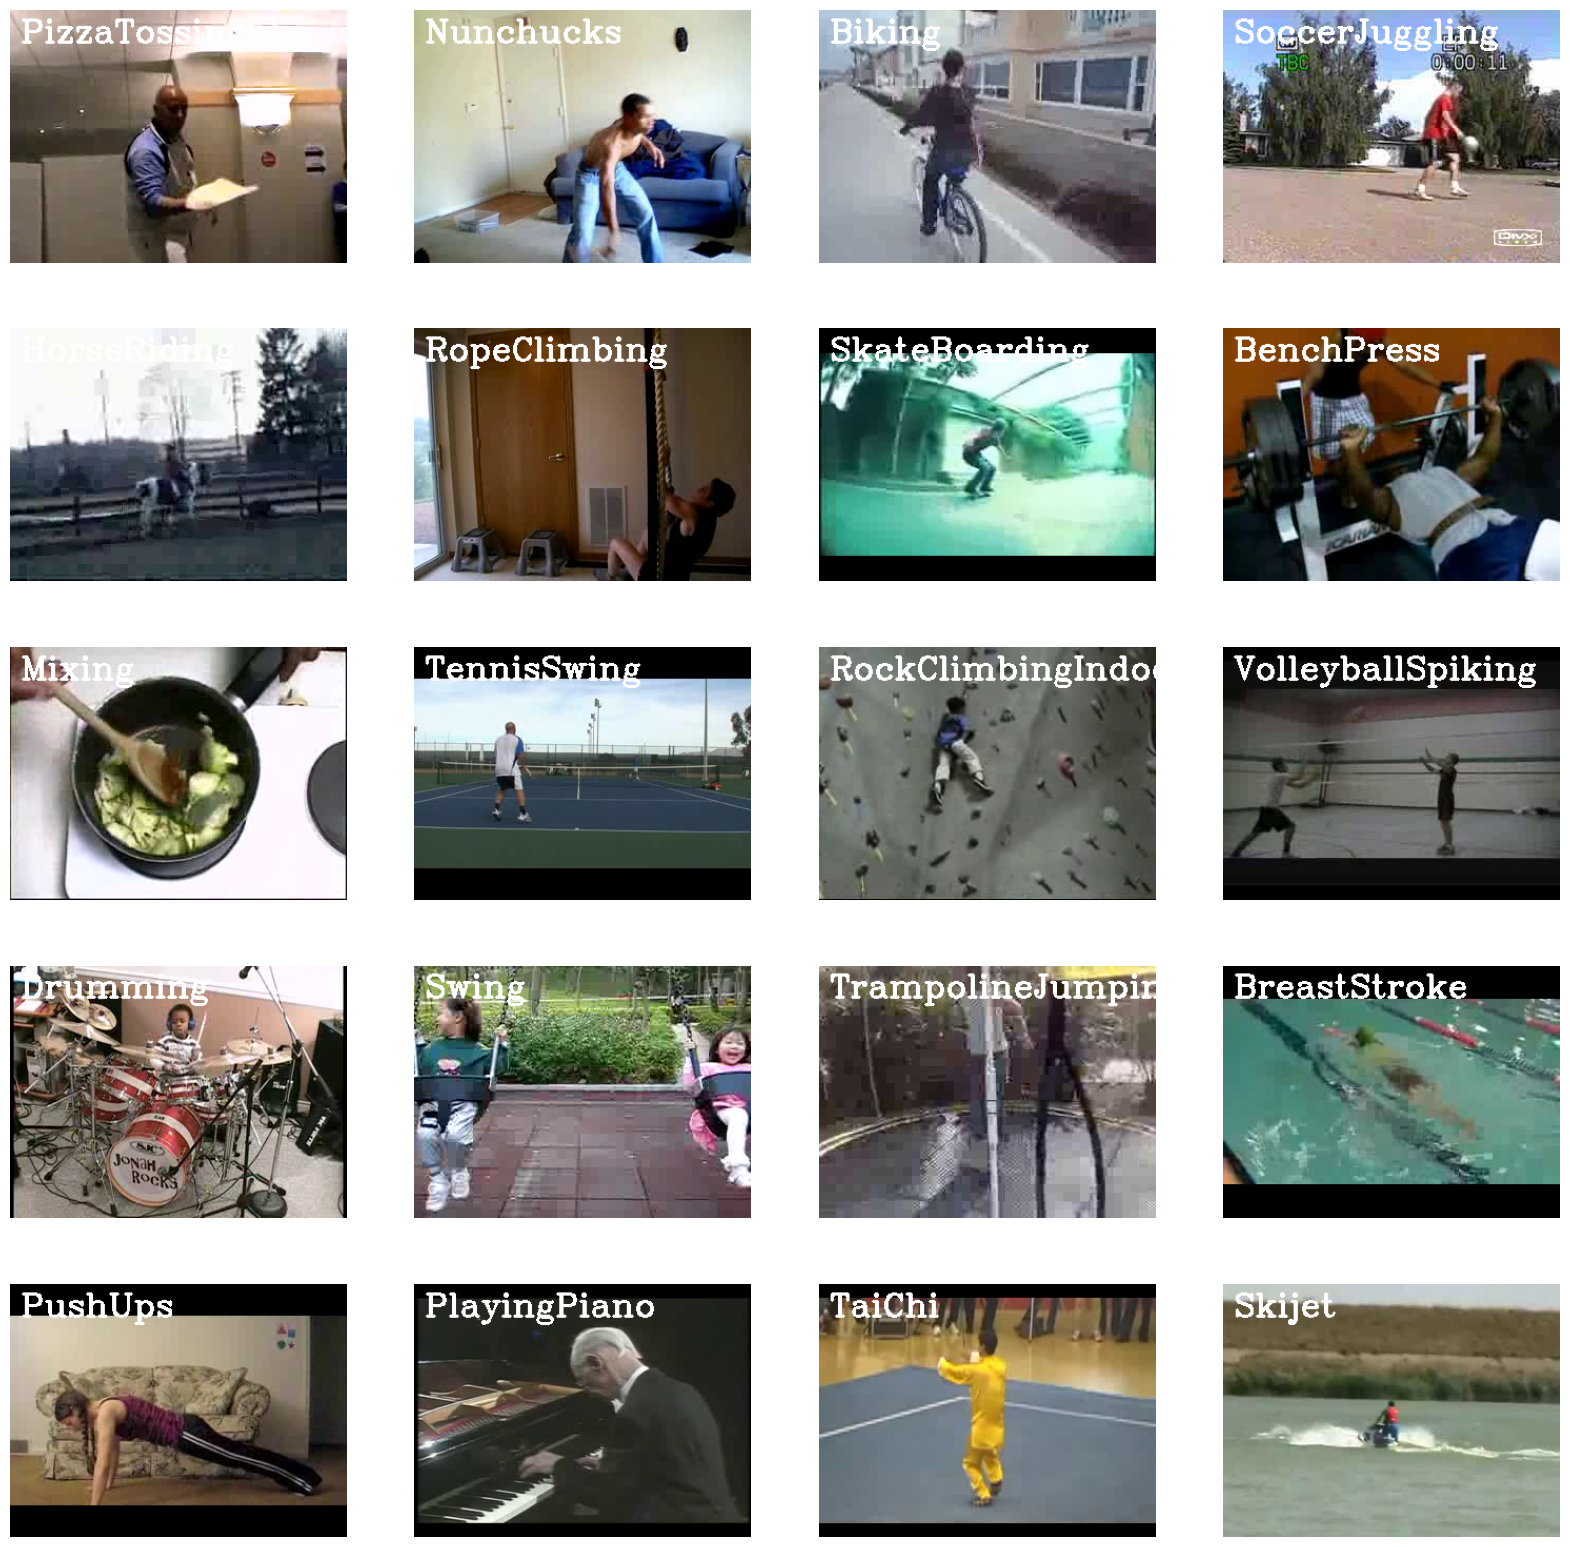

In [2]:
plt.figure(figsize=(20,20))

all_classes_names = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):

    # Retreive a class name using the random index
    selected_class_Name = all_classes_names[random_index]

    # Retreive the list of all the video files present in the randomly selected class directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retreived from the randomly selected class direcctory
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video file
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object
    video_reader.release()

    rgb_frame =cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1 , (255, 255, 255), 2)

    # Display the frame
    plt.subplot(5,4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')


# Step 2: Presprocess the Dataset

##### <p>Next, we will perform some preprocessing on the dataset. First, we will read the videos from the dataset and resize the frame of the videos to a <br> fixed width and height, to reduce the computations and normalized the data to range [0-1] by dividing the pixel values with 255, which makes convergence <br> faster while training the network.</p> <br>But first, let's initialize some constants

In [3]:
#  Spicify the height and width to whoch each video frame will be resized in our dataset.

IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used foe training. 
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "SWing", "HorseRace"]

#### Create a Function to Extract, Resize & Normalize Frames

In [9]:
def frames_extraction(video_path):

    # Declare a list to store video frames
    frames_list = []

    # Read the Video File using the videoCapture object
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        #  Reading the frame from the video
        success, frame = video_reader.read()

        # Check if video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the frame to fixed height and width
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object
    video_reader.release()

    # Return the frames list.
    return frames_list


#### Create a Function for Dataset Creation

In [10]:
def create_dataset():

    # Declared Empty Lists to store the features, labels and video file path values
    features = []
    labels =[]
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whole data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list
        for file_name in files_list:

            # Get the complete video path
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above
            # So ignore the videos having frames less than SEQUENCE_LENGTH
            
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their respective lists
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path
    return features, labels, video_files_paths

In [7]:
# Create the dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: SWing
Extracting Data of Class: HorseRace


In [8]:
# Using Kera's to_categorical method to convert labels into one-hot-encoding vectors
one_hot_encoded_labels = to_categorical(labels)

# Step 3: Split the Data into Train and Test Set

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True, random_state = seed_constant)

# Step 4: Implement the ConvLSTM Approach

In [10]:
def create_convlstm_model():

    model = Sequential()

    # Define the Model Architecture

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3,3), activation='tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences= True, input_shape = (SEQUENCE_LENGTH,
                                                                                        IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8 , kernel_size = (3, 3), activation='tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences = True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14 , kernel_size = (3, 3), activation='tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences = True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16 , kernel_size = (3, 3), activation='tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences = True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    # Display the model
    model.summary()

    # Return the constructed convlstm model
    return model

In [11]:
#  Construct the required convLSTM model
convlstm_model = create_convlstm_model()

# Display the success message
print("Model created successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

In [ ]:
plot_model(convlstm_model, to_file ="convlstm_model_structure_plot.png", show_shapes = True, show_layer_names = True)

# Step 4.2: Compile & Train the Model

In [13]:
early_stopping_callback = EarlyStopping(monitor = "val_loss", patience = 10, mode= "min", restore_best_weights = True)

# Compile the model and specify loss funciton, optimizer and metrics values to the model
convlstm_model.compile(loss="categorical_crossentropy", optimizer = "Adam", metrics=["accuracy"])

# Start training the model
convlstm_model_training_history = convlstm_model.fit( x = features_train, y= labels_train, epochs = 50, batch_size = 4,
                                                        shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50


73/73 [==============================] - 33s 352ms/step - loss: 1.3843 - accuracy: 0.2534 - val_loss: 1.3853 - val_accuracy: 0.2055
Epoch 2/50
73/73 [==============================] - 25s 339ms/step - loss: 1.3638 - accuracy: 0.3185 - val_loss: 1.3465 - val_accuracy: 0.4110
Epoch 3/50
73/73 [==============================] - 25s 340ms/step - loss: 1.3259 - accuracy: 0.3938 - val_loss: 1.2198 - val_accuracy: 0.4384
Epoch 4/50
73/73 [==============================] - 25s 347ms/step - loss: 1.2365 - accuracy: 0.4555 - val_loss: 1.2579 - val_accuracy: 0.4384
Epoch 5/50
73/73 [==============================] - 25s 339ms/step - loss: 1.1007 - accuracy: 0.5479 - val_loss: 1.0228 - val_accuracy: 0.6438
Epoch 6/50
73/73 [==============================] - 25s 343ms/step - loss: 0.9156 - accuracy: 0.6233 - val_loss: 0.8765 - val_accuracy: 0.6849
Epoch 7/50
73/73 [==============================] - 24s 334ms/step - loss: 0.7122 - accuracy: 0.7158 - val_loss: 0.7174 - val_accuracy: 0.7260
Epoch 8/50

## Evaluate the trained model 

In [15]:
# Evaluate the trained model
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 0s 104ms/step - loss: 0.6983 - accuracy: 0.7295


## Save the Model

In [16]:
# Get the loss and accuracy from model evaluation history
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format
# Get the current date and time object
# Convert the Datetime object to string according to the style mentioned in date_time format string

date_time_format = "%Y_%m_%d__%H_%M_%S"
current_date_time_dt = dt.datetime.now()
current_date_time_String = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models
model_file_name = f'convlstm_model__Date_Time_{current_date_time_String}__loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

# Save your model
convlstm_model.save(model_file_name)


# Step 4.3: Plot Model's Loss & Accuracy Curves

In [11]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    # Get metric values using metric names as identifiers
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph
    epochs = range(len(metric_value_1))

    # Plot the Graph
    plt.plot(epochs, metric_value_1, "blue", label= metric_name_1)
    plt.plot(epochs, metric_value_2, "red", label= metric_name_2)

    # Add title to the plot
    plt.title(str(plot_name))

    # Add legend to the plot
    plt.legend()


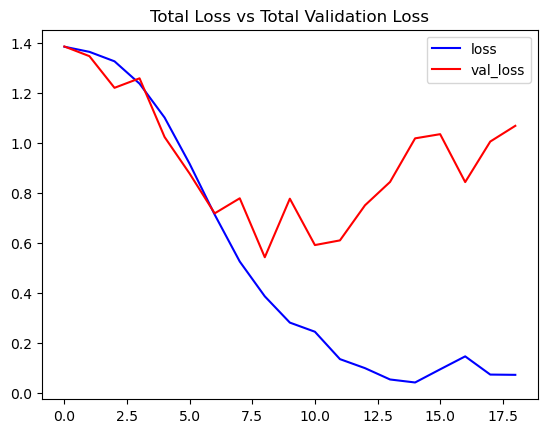

In [19]:
# Visualize the training and Validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

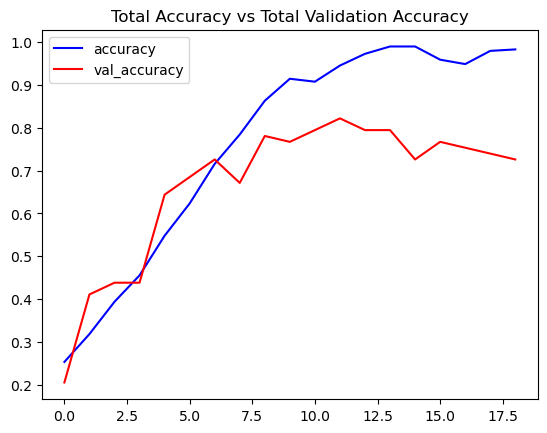

In [18]:
# Visualize the training and Validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Step 5.1: Construct the Model

In [12]:
def create_LRCN_model():

    # We will use a sequential model for model construction
    model = Sequential()

    # Define the Model Architecture
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding="same", activation="relu"),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4,4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu")))
    model.add(TimeDistributed(MaxPooling2D((4,4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding="same", activation="relu")))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding="same", activation="relu")))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    # model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    # Dsiplay the model summary
    model.summary()

    # Return the constructed LRCN model
    return model


In [13]:
# Construct the model required LRCN model
LRCN_model = create_LRCN_model()

# Display the success range
print("Model created successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 32)     0

# Step 5.2: Compile & Train the Model

In [17]:
# Create an instance of earlystopping callaback
early_stopping_callback = EarlyStopping(monitor="val_loss", patience= 15, mode="min", restore_best_weights= True)

# Compile the model and specify loss function, optimizer and metrics to the model
LRCN_model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=['accuracy'])

# Start training the model
LRCN_model_training_history = LRCN_model.fit( x= features_train, y = labels_train, epochs = 70, batch_size = 4, 
                                                shuffle= True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 13s 30ms/step - loss: 1.3902 - accuracy: 0.2979 - val_loss: 1.3823 - val_accuracy: 0.1781
Epoch 2/70
73/73 [==============================] - 1s 19ms/step - loss: 1.3337 - accuracy: 0.3459 - val_loss: 1.3723 - val_accuracy: 0.3014
Epoch 3/70
73/73 [==============================] - 1s 16ms/step - loss: 1.2496 - accuracy: 0.4623 - val_loss: 1.3907 - val_accuracy: 0.3014
Epoch 4/70
73/73 [==============================] - 1s 15ms/step - loss: 1.2146 - accuracy: 0.4486 - val_loss: 1.2707 - val_accuracy: 0.3699
Epoch 5/70
73/73 [==============================] - 1s 15ms/step - loss: 1.0675 - accuracy: 0.5445 - val_loss: 0.9349 - val_accuracy: 0.5890
Epoch 6/70
73/73 [==============================] - 1s 18ms/step - loss: 0.9219 - accuracy: 0.5993 - val_loss: 1.0028 - val_accuracy: 0.5753
Epoch 7/70
73/73 [==============================] - 1s 18ms/step - loss: 0.7512 - accuracy: 0.6952 - val_loss: 0.7498 - val_accuracy: 0.6849
Epoch 8/70
7

## Evaluating the trained Model

In [18]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 1s 105ms/step - loss: 0.5596 - accuracy: 0.8607


## Save the Model

After that, we will save the model for future uses using the same technique we had used for the previous model

In [19]:
# Get the loss and accuracy from model evaluation history
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format
# Get the current date and time object
# Convert the Datetime object to string according to the style mentioned in date_time format string

date_time_format = "%Y_%m_%d__%H_%M_%S"
current_date_time_dt = dt.datetime.now()
current_date_time_String = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models
model_file_name = f'LRCN_model__Date_Time_{current_date_time_String}__loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

# Save your model
LRCN_model.save(model_file_name)


In [13]:
from keras.models import load_model

# Provide the path to your h5 file
model_path = "LRCN_model__Date_Time_2024_04_30__17_06_37__loss_0.5595594048500061__Accuracy_0.8606557250022888.h5"

# Load the model
LRCN_model = load_model(model_path)


# 5.3: Plot Model's Loss & Accuracy

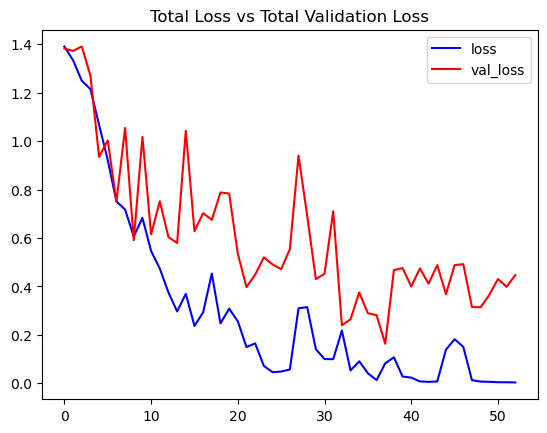

In [20]:
# Visualize the training and Validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

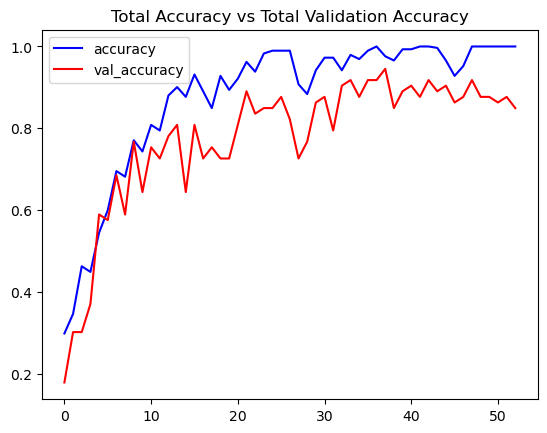

In [21]:
# Visualize the training and Validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Step 6: Test the Best Performing Model on Youtube videos

From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, we will puut the LRCN <br>
model to test on some youtube videos.

## Create a Function to Download Youtube Videos:

We will create a function <b>download_youtube_videos()</b> to download the Youtube videos first using the <b>pafy</b> library. The library only requires a URL <br>
to a video to download it along with its associated metadata like the title of the video.

In [14]:

# Function to download YouTube videos using pytube
def download_youtube_video(youtube_video_url, output_directory):
    try:
        yt = YouTube(youtube_video_url)
        video = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
        if video:
            video.download(output_directory)
            return yt.title
        else:
            print("No video available")
            return None
    except Exception as e:
        print(f"Error downloading video: {e}")
        return None

## Download a Test Video

Now we will utilize the function <b>download_youtube_videos()</b> created above to download a youtube video on which the LRCN model will be <br>
tested.

In [15]:
# Make the output directory if it does not exist
test_videos_directory = "test_videos"
os.makedirs(test_videos_directory, exist_ok=True)

In [18]:
# Download a YouTube Video
video_title = download_youtube_video('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

if video_title:
    # Get the YouTube Video's path we just downloaded
    input_video_file_path = os.path.join(test_videos_directory, f'{video_title}.mp4')
    print("Downloaded video:", input_video_file_path)
else:
    print("Video download failed.")

Downloaded video: test_videos\Test Video.mp4


## Create a Function To Perform Action Recognition Recognition on Videos

Next, we will create a function <b>predict_on_video()</b> that will simply read a video frame by from the path passed in as an argument and <br>will perform action recognition on video and save the results

In [16]:
def predit_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

    # Initialize the VideoCapture object to read from the video file
    video_reader = cv2.VideoCapture(video_file_path)

    # Get width and height of the video
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc("M", "P", "4", "V"),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width,original_video_height))
    
    # Declare a queue to store video frames
    frames_queue = deque(maxlen= SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video
    predicted_class_name = ''
    
    # Iterate until the video is accessed successfully
    while video_reader.isOpened():

        # Read the frame
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length 
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis= 0))[0]

            # Get the index of class with highest probability
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retreived index
            predicted_class_name = CLASSES_LIST[predicted_label] 

        # Write predicted class name on top of the frame
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)

        # Write the frame into the disk using the VideoWriter
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects
    video_reader.release()
    video_writer.release()




## Perform Action Recognition on the Test Video

Now we utilize the function <b>predict_on_video()</b> created above to perform action recognition on the test video we had downloaded using <br>the function <b>download_youtube_video()</b> and display the output video with the predicted action overlayed on it.

In [20]:
#  Consruct the output video path 
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video
predit_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None)).ipython_display()

1/1 [==============================] - 0s 45ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Create a Function To Perform a Single Prediction on Videos

Now let's create a function that will perofrm a single prediction for the complete Videos. We will extract evenly distributed <b>N (SEQUENCE_LENGTH)</b><br>from the entire video and pass them to the LRCN model. This approach is really useful when you are working with videos containing only<br>one activity as it saves unnecessary computations and time in tht scenario

In [17]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):

    # Initialize the VideoCapture object to read from te video file
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract
    frames_list=[]

    # Initialize a variable to store the prdicted action being performed in the video
    predicted_class_name=""

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterating the number of times equal to the fixed length of the sequence
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame 
        success, frame = video_reader.read()

        # Check if the frame is not read properly then break the loop
        if not success:
            break


        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that eac pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the pre-processed frames to the model and get the predicted probabilities
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retreived index 
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object
    video_reader.release() 



## Perform Single Prediction on a Test Video

Now we will utilize the function <b>predict_single_action()</b> created above to perform a single prediction on a complete youtube test video that <br>
we will download using the function <b>download_youtube_videos()</b>, we had created above.

In [6]:
import tensorflow as tf
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [18]:


# Download a YouTube Video
video_title = download_youtube_video('https://www.youtube.com/watch?v=F0uCFLriI0Q&pp=ygUSY2hpbGRyZW4gb24gc3dpbmdz', test_videos_directory)

if video_title:
    # Get the YouTube Video's path we just downloaded
    input_video_file_path = os.path.join(test_videos_directory, f'{video_title}.mp4')
    print("Downloaded video:", input_video_file_path)
    
    # Perform Single Prediction on the Test Video
    predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

    # Display the input video
    VideoFileClip(input_video_file_path, audio=False, target_resolution=(300, None)).ipython_display(maxduration=12000)

else:
    print("Video download failed.")

Downloaded video: test_videos\How to SWING on a Swing Set!! (Easy for Kids).mp4
1/1 [==============================] - 1s 1s/step
Action Predicted: SWing
Confidence: 0.9663376212120056
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
